# Machine Learning Engineer Nanodegree
## Capstone Project
Andrew O'Gorman - August 05, 2018


## I. Definition

### Project Overview
For my Capstone project I will be using a deep learning approach to attempt to solve the Humpback Whale Identification project on [Kaggle](https://www.kaggle.com/c/whale-categorization-playground). This is a similar image classification problem to the dog breed classification challenge in the Deep Learning section of the Machine Learning Nanodegree. I have chosen this domain as I care deeply about our oceans and maritime life. I have been fascinated by whales since visiting the [Natural History Museum](http://www.nhm.ac.uk/discover/news/2017/july/museum-unveils-hope-the-blue-whale-skeleton.html), London, as a child with my father and seeing the full skeleton of the blue whale. They are truly magnificent creatures; giants of the ocean and I feel passionately about helping organisations that support and monitor them. This project appeals to me as the work will help contribute to [Happy Whale's](https://happywhale.com/home) understanding of the movement of whales by using machine learning to dramatically increase the efficiency of this identification work. 

Whale tails (referred to as 'Flukes') are like a barcode or fingerprint, with enough information to identify an individual whale. [Traditionally](https://www.nationalgeographic.com/adventure/adventure-blog/2016/05/04/whos-that-whale-your-photo-could-help-i-d-a-humpback/), scientists and marine biologists have taken and amassed large numbers of photograpahs of whales and then had to manually attempt to match newly photographed whales with historic images. This process is time consuming and prone to a high degree of error, also there are challenges around getting the pictures due to the geographical spread of whales and the amount of time spent underwater. These are some of the reasons why this problem suits a machine learning approach.

Previous work was done at the [University of Texas](https://link.springer.com/chapter/10.1007/3-540-45103-X_16) in 2003 to identify Humpback and Gray Whales using a patch-matching technique as a follow-up phase to WhaleNet once they specified the fluke type. More recently a team at the [University of Catalunya in Barcelona](https://arxiv.org/pdf/1604.05605.pdf) used convolutional neural networks to test the feasibility of using deep learning in whale recognition using the NOAA Fisheries dataset. Their paper outlines a successful approach to applying CNNs to identification of the heads of whales and so this seems like a good approach to build upon in this capstone project.

I am keen to test my understanding of image recognition using Deep Learning as there are several additional projects I would like to conduct upon completion of my Nanodegree and so hope this Capstone Project will be the foundation of further work for me in this field.

The dataset I will be using to train the model can be found [here](https://www.kaggle.com/c/whale-categorization-playground/download/train.zip) and the testing dataset [here](https://www.kaggle.com/c/whale-categorization-playground/download/test.zip).

### Problem Statement
The problem is to use the existing dataset of whale fluke images to build an understanding of each whale's unique characteristics of their tails. By using this understanding, we should then be able to take a new picture of a whale fluke and determine whether it matches a previously seen whale or whether it is in fact a new whale not previously seen in our dataset. 

This problem is an image recognition challenge given the unique features of a [whale's fluke](http://www.alaskahumpbacks.org/matching.html) as seen below:

<img src="files/fluke.jpg">

This problem is a good one to solve as understanding and tracking whale populations across the globe will help in several fields including ocean conservation and global climate change. 

### Metrics
The owners of the Kaggle competition hold a labelled list of the 15,611 testing images which result submissions are compared against. For each image in the test set I will predict up to 5 labels for the whale ID (e.g. **w_1287fbc**), where a whale is not predicted to be one of the existing whales in the training data they will be labelled as **new_whale**. The submissions file will contain a header and have the following format:

    Image,Id
    
    00029b3a.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
    
    0003c693.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46

The submissions are evaluated according to the Mean Average Precision (MAP) as seen below:

    MAP@5 = \frac{1}{U} \sum_{u=1}^{U}  \sum_{k=1}^{min(n,5)} P(k)

Where **U** is the number of images, **P(k)** is the precision at cut-off **k**, and **n** is the number predictions per image. Scores are between 0 and 1 with a score of 1 being a perfect match with no error.


## II. Analysis

### Data Exploration
The dataset I am using was provided by Happy Whale, a citizen science organisation helping to track individual whales throughout the world's oceans. The images were gathered from research institutions and public contributions. The images specifically targeted whale flukes with the aim of being used to help identify the migration patterns of whales over time so as a dataset is ideally suited to the proposed problem.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

training_df = pd.read_csv('../capstone/train.csv')
number_whales = len(training_df['Id'].unique())

print("Total images in the training data =",len(os.listdir("../capstone/train")) )
print("Total images in the test data = ",len(os.listdir("../capstone/test")))
print("Total unique whales in training data =",number_whales)

Total images in the training data = 9850
Total images in the test data =  15610
Total unique whales in training data = 4251


### Exploratory Visualization
The data consists of over 25,000 images of whale flukes, with 9850 labelled images in the training set and 15,610 images in the testing set. In total the dataset contains images for 4251 different whales if you include the category of new_whale. Each image varies in size (number of pixels), colour, quality (sharpness) and orientation as we can see below:

| Colour landscape | Grayscale and blurry | Colour portrait |
| - | - | - |
|<img src="files/train/6c54a646.jpg">|<img src="files/train/e976465c.jpg">|<img src="files/train/ea5f45ca.jpg">|

I will first look to pre-process the data to standardise the size, colour and proportions of all the images. This will allow me to build, train and test a deep learning algorithm to help identify whales within the dataset. The data is already split into training and testing sets, however, I will look to further subdivide the training set as I build my model.


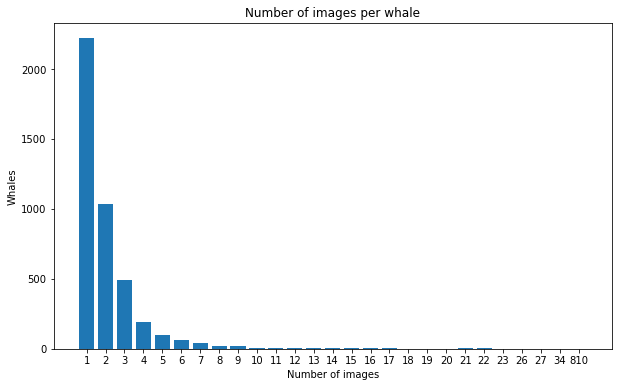

In [9]:
import math
from collections import Counter

buckets = Counter(training_df['Id'].value_counts().values)

plt.figure(figsize=(10, 6))
plt.bar(range(len(buckets)), list(buckets.values())[::-1])
plt.xticks(range(len(buckets)), list(buckets.keys())[::-1])
plt.title("Number of images per whale")
plt.xlabel('Number of images')
plt.ylabel('Whales')

plt.show()

Initial analysis of the data reveals that of the 4251 whales in the dataset over 2000 of them have only one image, with around 4000 of the whales having less than 5 images to train on. I will therefore use Data Augmentation to help boost the number of training images for each whale which I will discuss below.

In [16]:
from PIL import Image

def is_grey_scale(img_path):
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False
    return True

greyscale = [is_grey_scale(f'../capstone/train/{i}') for i in training_df['Image'].sample(frac=0.1)]
grey_percentage = round(sum([i for i in greyscale]) / len([i for i in greyscale]) * 100, 2)

print(f"Percentage of grey images: {grey_percentage}")

Percentage of grey images: 48.93


By using the above [code]((https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli) we can see that we have almost an equal split of grayscale and colour images in the training data set. I will therefore look to convert all images (both training and testing) to greyscale in my data pre-processing step.

Given the three images above are all different sizes I can also explore how the size of the images varies across the dataset.

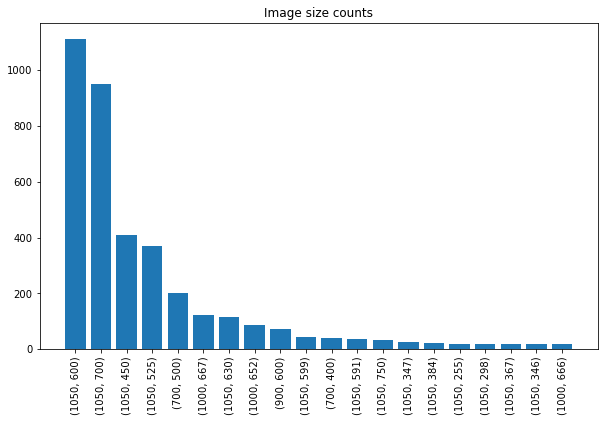

In [13]:
img_sizes = Counter([Image.open(f'../capstone/train/{i}').size for i in training_df['Image']])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=90)
plt.title("Image size counts")

plt.show()

As we can clearly see the image size varies significantly across the dataset. I will look to address this in the Data Preprocessing section

### Algorithms and Techniques
I will be using a Deep Learning approach for this image identification problem. Deep Learning makes use of neural networks which aim to mimic how the brain operates with neurons used to fire pieces of information through a network to produce an output. By using this approach and building complex neural networks, Deep Learning can be more effective at determining the important features in a given image than a human. 

Specifically, I intend to use Convolutional Neural Networks (CNNs) for this problem. I have chosen to use CNNs for several reasons:

-  CNNs maintain spatial information by taking matrices as inputs when compared to traditional Multilayer Perceptrons. This allows us to use fewer weights as some parameters are shared, hence lowering the computational cost and training time.

- CNNs work well across images where there are distortions due to lighting conditions, horizontal/vertical shifts, different poses etc.

- They are very good at identifying patterns within images by using filters to find specific groups of pixel groupings that are important.

### Benchmark
The benchmark score I will be comparing against was achieved using a technique known as [Perceptual hashing](https://en.wikipedia.org/wiki/Perceptual_hashing) (pHash). The pHash algorithm produces a fingerprint for each image which are analogous if features in the images are similar. This technique has been used previously to identify cases of online copyright infringement and also in digital forensics work due to its ability to have a correlation between hashes so similar images can be identified. 

The pHash technique is able to identify which whale IDs the image is most similar to and then submit their 5 most likely matches for each image. This benchmark submission was then measured using the MAP formula below to get a Mean Average Position score of 0.36075.

## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_

To do:

* write code for one image to test it, then connect to TensorFlow and run for all images and then save in augmented training folder.
* convert to greyscale
* convert all images to standard size
* remove any text/background noise from image by focusing on flukes
* ensure all images are rotated so fluke pointing upwards
* augment images to include variation and boost numbers per image
* check to make sure all above has worked
* once happy with this I will need to run same preprocessing over testing data also

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

Preparing images


NameError: name 'image' is not defined

In [ ]:
# import the data

train_images = glob("../input/train/*jpg")
test_images = glob("../input/test/*jpg")
df = pd.read_csv("../input/train.csv")

df["Image"] = df["Image"].map( lambda x : "../input/train/"+x)
ImageToLabelDict = dict( zip( df["Image"], df["Id"]))

# resize and convert to black and white

SIZE = 64
#image are imported with a resizing and a black and white conversion
def ImportImage( filename):
    img = Image.open(filename).convert("LA").resize( (SIZE,SIZE))
    return np.array(img)[:,:,0]
train_img = np.array([ImportImage( img) for img in train_images])
x = train_img

In [26]:
# one hot encoding of the images

class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)

y = list(map(ImageToLabelDict.get, train_images))
lohe = LabelOneHotEncoder()
y_cat = lohe.fit_transform(y)

NameError: name 'cv2' is not defined

In [ ]:
# constructing class weights

WeightFunction = lambda x : 1./x**0.75
ClassLabel2Index = lambda x : lohe.le.inverse_tranform( [[x]])
CountDict = dict( df["Id"].value_counts())
class_weight_dic = { lohe.le.transform( [image_name])[0] : WeightFunction(count) for image_name, count in CountDict.items()}
del CountDict

In [ ]:
# check to see if resizing and greyscale conversion have worked

def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    
plotImages( x)

In [ ]:
#Image augmentation

#use of an image generator for preprocessing and data augmentation
x = x.reshape( (-1,SIZE,SIZE,1))
input_shape = x[0].shape
x_train = x.astype("float32")
y_train = y_cat

image_gen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

#training the image preprocessing
image_gen.fit(x_train, augment=True)

#visualization of some images out of the preprocessing
#augmented_images, _ = next( image_gen.flow( x_train, y_train.toarray(), batch_size=4*4))
#plotImages( augmented_images)

In [ ]:
# build and train model

batch_size = 128
num_classes = len(y_cat.toarray()[0])
epochs = 9

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

model = Sequential()
model.add(Conv2D(48, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(48, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.33))
model.add(Flatten())
model.add(Dense(36, activation='sigmoid'))
model.add(Dropout(0.33))
model.add(Dense(36, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()
model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
          steps_per_epoch=  x_train.shape[0]//batch_size,
          epochs=epochs,
          verbose=1,
          class_weight=class_weight_dic)

#score = model.evaluate(x_train, y_train, verbose=0)
#print('Training loss: {0:.4f}\nTraining accuracy:  {1:.4f}'.format(*score))

In [ ]:
#predictions for test samples and prediction export

import warnings
from os.path import split

with open("sample_submission.csv","w") as f:
    with warnings.catch_warnings():
        f.write("Image,Id\n")
        warnings.filterwarnings("ignore",category=DeprecationWarning)
        for image in test_images:
            img = ImportImage( image)
            x = img.astype( "float32")
            #applying preprocessing to test images
            x = image_gen.standardize( x.reshape(1,SIZE,SIZE))
            
            y = model.predict_proba(x.reshape(1,SIZE,SIZE,1))
            predicted_args = np.argsort(y)[0][::-1][:5]
            predicted_tags = lohe.inverse_labels( predicted_args)
            image = split(image)[-1]
            predicted_tags = " ".join( predicted_tags)
            f.write("%s,%s\n" %(image, predicted_tags))

## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_

### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_



## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_

### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_

## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?




### Resources

* https://www.kaggle.com/c/whale-categorization-playground
* http://www.nhm.ac.uk/discover/news/2017/july/museum-unveils-hope-the-blue-whale-skeleton.html
* https://happywhale.com/home
* https://www.nationalgeographic.com/adventure/adventure-blog/2016/05/04/whos-that-whale-your-photo-could-help-i-d-a-humpback/
* https://link.springer.com/chapter/10.1007/3-540-45103-X_16
* https://arxiv.org/pdf/1604.05605.pdf
* http://www.alaskahumpbacks.org/matching.html
* https://en.wikipedia.org/wiki/Perceptual_hashing
* https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli

